In [3]:
import joblib
(A,terms,snippets) = joblib.load( "articles-raw.pkl" )
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Loaded 21879 X 2452 document-term matrix


In [ ]:
kmin, kmax = 4, 15

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
topic_models = []
#k'nin her değerini deneyin
for k in range(kmin,kmax+1):
    print("Applying LDA for k=%d ..." % k )
    #LDA
    model = LatentDirichletAllocation(n_components=k, max_iter=10, learning_method='batch', learning_offset=50.,random_state=0).fit(A)
    W = model.fit_transform( A )
    H = model.components_    
    #sonraya sakla
    topic_models.append( (k,W,H) )

In [ ]:
import os.path
raw_documents = []
with open( "batı.csv" ,"r", encoding = "utf-8") as fin:
    for line in fin.readlines():
        raw_documents.append( line.strip().lower() )
print("Read %d raw text documents" % len(raw_documents))

In [ ]:
custom_stop_words = []
with open( "stopwords.txt", "r",  ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip().lower() )
# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words) )

In [ ]:
import re
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

In [ ]:
import gensim
docgen = TokenGenerator( raw_documents, custom_stop_words )
# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, vector_size=500, min_count=20, sg=1)

In [ ]:
w2v_model.save("w2v-model-lda.bin")

In [10]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [11]:
import numpy as np
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [12]:
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=0.3244
K=05: Coherence=0.3583
K=06: Coherence=0.3286
K=07: Coherence=0.3447
K=08: Coherence=0.3572
K=09: Coherence=0.3741
K=10: Coherence=0.3688
K=11: Coherence=0.3512
K=12: Coherence=0.3743
K=13: Coherence=0.3741
K=14: Coherence=0.3836
K=15: Coherence=0.3831


In [13]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

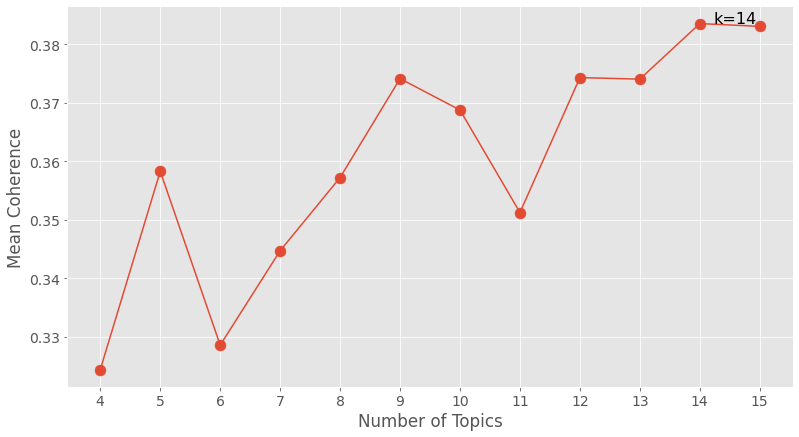

In [14]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [15]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

In [17]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: patron, dog, times, ukraine, agree, needs, minister, dogecoin, rogozin, cooler
Topic 02: ukraine, russia, war, putin, russian, people, just, country, putins, dont
Topic 03: war, russian, ukraine, news, crimes, life, first, soldier, invasion, russia
Topic 04: russians, attack, russia, isnt, wont, nyt, full, russianwarcrimes, russiansoldiers, fuck
Topic 05: conflict, peace, invade, invaded, trump, wheat, national, covid, defeat, whats
Topic 06: ukraine, russian, ukrainewar, ukrainian, russia, mariupol, ukraineunderattaсk, russiaukrainewar, army, kyiv
Topic 07: ukraine, russia, nato, war, putin, day, still, see, finland, take
Topic 08: world, russias, biden, invasion, countries, food, western, sanctions, gas, security
Topic 09: china, taiwan, military, defend, standwithukraine, militarily, usa, down, destruction, key
Topic 10: elonmusk, russiaukraine, poland, ukrainians, happened, work, victory, putting, actually, watch
Topic 11: eastern, forces, may, city, armed, donbas, region